<a href="https://colab.research.google.com/github/anderhos/Applied-Machine-Learning/blob/master/cnn_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CA2 - DAT300 - Compulsory Assignment 2
 - Kaggle name : Group_2
 - Group number : Group 2 
 - Members : Anders Mølmen Høst , Ghazal Azadi ,Meera Joseph

## Cloud segmentation on satellite images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd ~

/root


In [ ]:
ls

In [ ]:
mkdir ~/.kaggle

In [ ]:
mv /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

IndexError: ignored

In [ ]:
 # Check existence of file
!ls /.kaggle
!cat /.kaggle/kaggle.json

ls: cannot access '/.kaggle': No such file or directory
cat: /.kaggle/kaggle.json: No such file or directory


In [ ]:
 # Notice the difference in path names with/without ~
!mkdir -p ~/.kaggle
!cp /.kaggle/kaggle.json ~/.kaggle/

In [ ]:
 # Install Python part of kaggle
!pip install kaggle

In [ ]:
cd /content

/content


In [ ]:
!kaggle competitions download -c dat300-h2020-ca2

 87% 65.0M/75.1M [00:00<00:00, 111MB/s] 
100% 75.1M/75.1M [00:00<00:00, 190MB/s]
 60% 11.0M/18.4M [00:00<00:00, 93.4MB/s]
100% 18.4M/18.4M [00:00<00:00, 118MB/s] 
 99% 454M/460M [00:03<00:00, 147MB/s]
100% 460M/460M [00:03<00:00, 131MB/s]


In [ ]:
!unzip /content/test.h5.zip -d /content/

Archive:  /content/test.h5.zip
  inflating: /content/test.h5        


In [ ]:
!unzip /content/train.h5.zip -d /content/

Archive:  /content/train.h5.zip
  inflating: /content/train.h5       


### Load modules

In [ ]:
import tensorflow as tf
from PIL.Image import fromarray
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Conv2DTranspose
from tensorflow.keras import layers
from tensorflow.keras import activations
import h5py
import numpy as np

from keras import backend as K
from numpy import concatenate

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model


###1. Get data from the HDF5 file:

In [ ]:
with h5py.File('/content/train.h5', 'r') as hf:
    print(hf.keys())

<KeysViewHDF5 ['X', 'y']>


In [ ]:
with h5py.File('train.h5', 'r') as hf:
    X_data = hf['X'][:]
    y_data = hf['y'][:]

In [ ]:
with h5py.File('test.h5', 'r') as hf:
    X_test = hf['X'][:]

In [ ]:
X_data.shape

(3000, 128, 128, 4)

### 2. Preprocessing

Plotting the first 9 images and 
corresponding masks

In [ ]:
def plot_img(X):
  # We need our date normalized and in floating point representation
  # to be able to plot our data using imshow
  X = X.astype('float32')
  X = X/np.max(X)
  for i in range(0, 9):
      plt.subplot(330 + 1 + i)
      plt.imshow(X[i,:,:,:-1])
  return plt.show()









  

In this plot, we tried to visualize our X_data. Our X_data basically consists of 3000 images with dimesions of 128*128 with 4 color channels. (X_data.shape)

However in this plot we are visualizing 9 images (randomly) with indices of 331-339. As its been shown, some pictures consist of clouds and some don't. Our main goal at the end is to categorize these images as if they include clouds or not. 

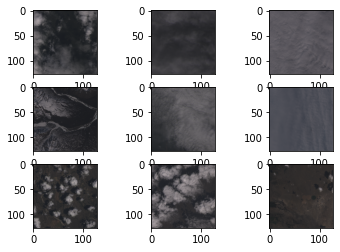

In [ ]:
plot_img(X_data)

In [ ]:
# Normalizing y_data
y_data = y_data/255

In [ ]:
def plot_mask(y):
  for i in range(0, 9):
      plt.subplot(330 + 1 + i)
      plt.imshow(y_data[i,:,:,0])
  return plt.show

What we do here is to visualize the target. As we said before our goal in this problem is to find a model in which it can categorize the given images based on the fact that if they consist clouds or not. Therefore what we have in the y_data is reflecting this issue. Looking at some plot masks of y_data (below image) we can obviously recognize binary classification of the target.

<function matplotlib.pyplot.show>

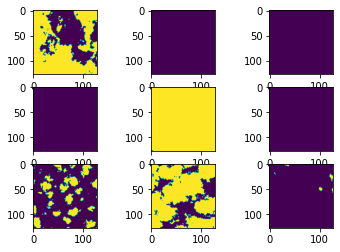

In [ ]:
plot_mask(y_data)

In [ ]:
# Partition and split into training and validation data 
X_train, y_train = X_data[:2400, :], y_data[:2400]
X_valid, y_valid = X_data[2400:3000, :], y_data[2400:3000]

In [ ]:
print("Shape of X_data: ",X_data.shape)
print("Shape of y_data: ",y_data.shape)
print("Shape of X_train: ",X_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of X_valid: ",X_valid.shape)
print("Shape of y_valid: ",y_valid.shape)

Shape of X_data:  (3000, 128, 128, 4)
Shape of y_data:  (3000, 128, 128, 1)
Shape of X_train:  (2400, 128, 128, 4)
Shape of y_train:  (2400, 128, 128, 1)
Shape of X_valid:  (600, 128, 128, 4)
Shape of y_valid:  (600, 128, 128, 1)


In [ ]:
# Standardize data pixel wise

mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train, axis=0)

X_train_centered = (X_train - mean_vals) / std_val
X_valid_centered = (X_valid - mean_vals) / std_val
X_test_centered = (X_test  - mean_vals) / std_val

In [ ]:
X_train_centered.shape

(2400, 128, 128, 4)

In [ ]:
X_valid_centered.shape

(600, 128, 128, 4)

In [ ]:
X_test_centered.shape

(500, 128, 128, 4)

In [ ]:
y_valid.shape

(600, 128, 128, 1)

###TASK :
##### Create a basic U-Net with optional dropout. Use a proportion of the images for validation when training. The minimum requirement is to tune the following parameters: number of convolutional filters, dropout and learning rate.  Report strategies and scores leading up to the final choice. If time permits, we recommend adding augmentation (both images and masks) and changing the loss function, e.g. implementing F1. More exotic networks and tuning is also allowed as long as you show that you know how to use U-Nets too.

### 3. Unet model for image segmentation 
using sigmoid as the activation function 

In [ ]:
"""
Version of U-Net with dropout and size preservation (padding= 'same')
""" 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

- It should be noted that in the covolution part of the code, we also examined threshold Relu activation. However with different values of the threshold it did not contribute to the improvement of the model significantly.So we fixed the activation function as Relu.

- Another important thing about the above code is that in the dense layer, since we had the binary classification, we chose to use Sigmoid activation which is appropriate for binary classification problems.

#### 3.1 Code for F1, precision and recall for keras model

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice
from keras import backend as K

smooth = 0.0000001


def jacc_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

### 3.2 Build the unet model with input image and 64 filters 

In [ ]:
input_img = Input(shape=(128,128,4))
model = get_unet(input_img, n_filters = 64, dropout = 0, batchnorm = True, n_classes = 1)
#model.summary()

- we choose the input with the same dimension of the X_data. (one sample of 128*128 dimension with 4 color channels)
- We also have exmained filters of 32 with 50% dropout which leaded to 91% F1_score.
- Another alternative which we examined was 16 filters with 30% dropout which gave us 88% of F_1 score.
- Among all the best combination of hyper-parameters was 64 filters with no dropout which took us to get the best F_1 score of 95%.


### 3.2.1 Inspect the model

Use summary method to print a simple description of the model

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### 3.3 Compile the model and train the model on the training data , evaluate the model performance on the validation data set



In [ ]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adamax'), loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m,dice_coef])

- For model compile, we also tried different types of loss and optimization such as MeanAbsoluteError (https://www.tensorflow.org/api_docs/python/tf/keras/losses) or SGD (https://www.tensorflow.org/api_docs/python/tf/keras/optimizers). However the best combination was Adamax and binary_crossentropy.

- What we observed here was that the learning rate can change the performance of the model significantly. And by test and error, seems like for this specific problem, learning rate of 0.0001 works well , so we  tried three different learning_rates: 0.001, 0.001 and 0.0001 and seems like the smallest one was the best. Smaller steps towards the optimum value leads to the best conclusion, apparently.
- We tried different batch sizes of 28,35,50 and it was found that a batchsize 50 was giving better results.


In [ ]:
import time
tic = time.time()
results = model.fit(X_train_centered, y_train, batch_size=50, epochs=20,validation_data=(X_valid_centered, y_valid))
loss, accuracy, f1_score, precision, recall,dice_coef = model.evaluate(X_valid_centered, y_valid, verbose=0)

toc = time.time()

print(f"Done in {(toc - tic):.1f} seconds")

Epoch 1/20
48/48 [==============================] - 44s 916ms/step - loss: 0.3582 - acc: 0.8430 - f1_m: 0.8489 - precision_m: 0.8330 - recall_m: 0.8713 - dice_coef: 0.5783 - val_loss: 0.4311 - val_acc: 0.8181 - val_f1_m: 0.7778 - val_precision_m: 0.8877 - val_recall_m: 0.6981 - val_dice_coef: 0.4668
Epoch 2/20
48/48 [==============================] - 43s 900ms/step - loss: 0.2174 - acc: 0.9172 - f1_m: 0.9161 - precision_m: 0.9236 - recall_m: 0.9111 - dice_coef: 0.6447 - val_loss: 0.3568 - val_acc: 0.8070 - val_f1_m: 0.7866 - val_precision_m: 0.8074 - val_recall_m: 0.7745 - val_dice_coef: 0.5481
Epoch 3/20
48/48 [==============================] - 43s 898ms/step - loss: 0.1906 - acc: 0.9264 - f1_m: 0.9250 - precision_m: 0.9350 - recall_m: 0.9172 - dice_coef: 0.6597 - val_loss: 0.2247 - val_acc: 0.9020 - val_f1_m: 0.8936 - val_precision_m: 0.8950 - val_recall_m: 0.8956 - val_dice_coef: 0.6010
Epoch 4/20
48/48 [==============================] - 43s 896ms/step - loss: 0.1687 - acc: 0.9352 -

# Tuning of number of filters

###A. Plotting the variation of dice coefficient and f1 score for 100 epochs to find the epoch at which best performance is observed for 64 filters

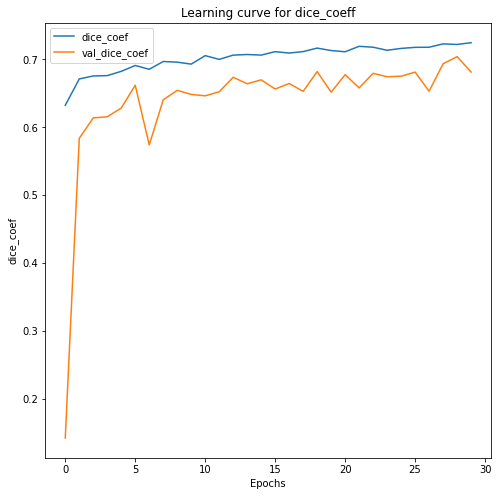

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve for dice_coeff with 64 filters")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();

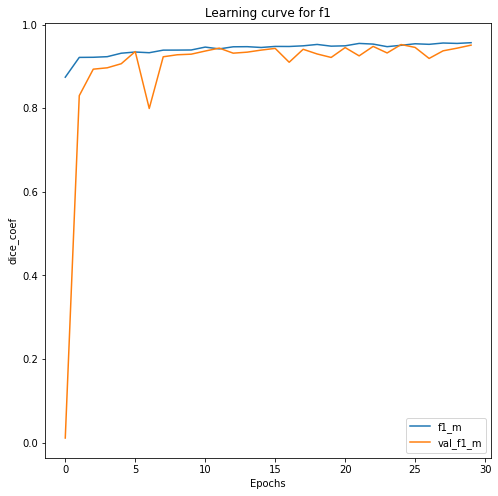

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve for f1 with 64 filters")
plt.plot(results.history["f1_m"], label="f1_m")
plt.plot(results.history["val_f1_m"], label="val_f1_m")
plt.xlabel("Epochs")
plt.ylabel("f1")
plt.legend();

- After training our model, we observe that the validation data generalises the training data well at 20 epochs with batch size 50 for 64 filters. We continue using the same settings in our model on the whole training data. 
- After 20 epochs we can observe that the validation dice_coefficient shows overfitting.


### B.Plotting the variation of dice coefficient and f1 score for 100 epochs to find the epoch at which best performance is observed for 8 filters

Epoch 1/20
48/48 [==============================] - 5s 105ms/step - loss: 0.6883 - acc: 0.6058 - f1_m: 0.6716 - precision_m: 0.5798 - recall_m: 0.8061 - dice_coef: 0.4669 - val_loss: 0.6995 - val_acc: 0.5650 - val_f1_m: 0.6476 - val_precision_m: 0.5170 - val_recall_m: 0.8693 - val_dice_coef: 0.4367
Epoch 2/20
48/48 [==============================] - 5s 95ms/step - loss: 0.5693 - acc: 0.7496 - f1_m: 0.7622 - precision_m: 0.7254 - recall_m: 0.8091 - dice_coef: 0.4926 - val_loss: 0.6091 - val_acc: 0.7285 - val_f1_m: 0.7410 - val_precision_m: 0.6642 - val_recall_m: 0.8416 - val_dice_coef: 0.4612
Epoch 3/20
48/48 [==============================] - 5s 96ms/step - loss: 0.4964 - acc: 0.7971 - f1_m: 0.7979 - precision_m: 0.7921 - recall_m: 0.8074 - dice_coef: 0.5106 - val_loss: 0.5391 - val_acc: 0.7862 - val_f1_m: 0.7904 - val_precision_m: 0.7262 - val_recall_m: 0.8707 - val_dice_coef: 0.4728
Epoch 4/20
48/48 [==============================] - 5s 96ms/step - loss: 0.4484 - acc: 0.8229 - f1_m: 

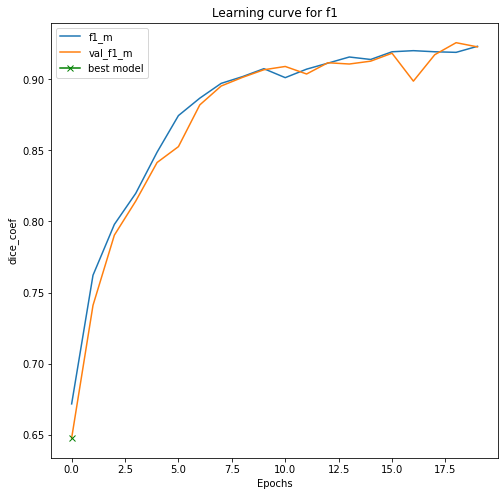

In [ ]:
input_img = Input(shape=(128,128,4))
model8 = get_unet(input_img, n_filters = 8, dropout = 0, batchnorm = True, n_classes = 1)

# compile the model
model8.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adamax'), loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m,dice_coef])

import time
tic = time.time()
results = model8.fit(X_train_centered, y_train, batch_size=50, epochs=20,validation_data=(X_valid_centered, y_valid))
loss, accuracy, f1_score, precision, recall,dice_coef = model8.evaluate(X_valid_centered, y_valid, verbose=0)

toc = time.time()

print(f"Done in {(toc - tic):.1f} seconds")

plt.figure(figsize=(8, 8))
plt.title("Learning curve for f1")
plt.plot(results.history["f1_m"], label="f1_m")
plt.plot(results.history["val_f1_m"], label="val_f1_m")
plt.plot( np.argmin(results.history["val_f1_m"]), np.min(results.history["val_f1_m"]), marker="x", color="g", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();



C.Plotting the variation of dice coefficient and f1 score for 100 epochs to find the epoch at which best performance is observed for 16 filters

Epoch 1/20
48/48 [==============================] - 9s 181ms/step - loss: 0.6182 - acc: 0.6747 - f1_m: 0.7321 - precision_m: 0.6276 - recall_m: 0.8852 - dice_coef: 0.4907 - val_loss: 0.5923 - val_acc: 0.7187 - val_f1_m: 0.7034 - val_precision_m: 0.6892 - val_recall_m: 0.7243 - val_dice_coef: 0.4250
Epoch 2/20
48/48 [==============================] - 8s 167ms/step - loss: 0.4229 - acc: 0.8374 - f1_m: 0.8483 - precision_m: 0.7939 - recall_m: 0.9158 - dice_coef: 0.5447 - val_loss: 0.4775 - val_acc: 0.7937 - val_f1_m: 0.7668 - val_precision_m: 0.8013 - val_recall_m: 0.7385 - val_dice_coef: 0.4590
Epoch 3/20
48/48 [==============================] - 8s 169ms/step - loss: 0.3298 - acc: 0.8885 - f1_m: 0.8899 - precision_m: 0.8739 - recall_m: 0.9097 - dice_coef: 0.5740 - val_loss: 0.4225 - val_acc: 0.8104 - val_f1_m: 0.7907 - val_precision_m: 0.8056 - val_recall_m: 0.7793 - val_dice_coef: 0.4962
Epoch 4/20
48/48 [==============================] - 8s 169ms/step - loss: 0.2831 - acc: 0.9100 - f1_

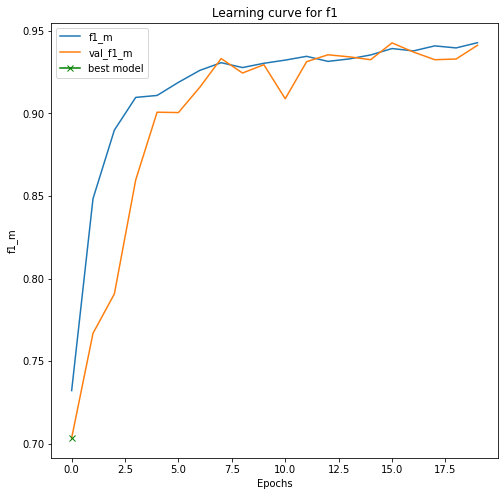

In [ ]:
input_img = Input(shape=(128,128,4))
model16 = get_unet(input_img, n_filters = 16, dropout = 0, batchnorm = True, n_classes = 1)

# compile the model
model16.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adamax'), loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m,dice_coef])

import time
tic = time.time()
results = model16.fit(X_train_centered, y_train, batch_size=50, epochs=20,validation_data=(X_valid_centered, y_valid))
loss, accuracy, f1_score, precision, recall,dice_coef = model16.evaluate(X_valid_centered, y_valid, verbose=0)

toc = time.time()

print(f"Done in {(toc - tic):.1f} seconds")

plt.figure(figsize=(8, 8))
plt.title("Learning curve for f1")
plt.plot(results.history["f1_m"], label="f1_m")
plt.plot(results.history["val_f1_m"], label="val_f1_m")
plt.plot( np.argmin(results.history["val_f1_m"]), np.min(results.history["val_f1_m"]), marker="x", color="g", label="best model")
plt.xlabel("Epochs")
plt.ylabel("f1_m")
plt.legend();



### 4. Train the final model on whole training data and then make the predictions on the test data

- Standardised the whole X_data before fitting the model

In [ ]:
mean_vals = np.mean(X_data, axis=0)
std_val = np.std(X_data)

X_data_centered = (X_data - mean_vals)/std_val

print(X_data_centered.shape)

(3000, 128, 128, 4)


In [ ]:
model.fit(X_data_centered, y_data, epochs=20, verbose=0, batch_size=50)

In [ ]:
model.evaluate(X_data_centered, y_data, verbose=0)

[0.09390587359666824,
 0.9629580974578857,
 0.9611641764640808,
 0.9696094989776611,
 0.9530960917472839,
 0.7130821943283081]

In [ ]:
y_pred = model.predict(X_test_centered)

In [ ]:
y_pred.shape

(500, 128, 128, 1)

### 4.1 Flatten the predected y data and map it to True and false , where True stands for cloud and False for not a cloud , covert it to csv and upload to kaggle 

In [ ]:
y_pred2=np.where(y_pred[:,:,:,] >= 0.5, 'True', 'False')
y_pred2=y_pred2.flatten()

In [ ]:
solution = pd.DataFrame(columns = ['Predicted'], data = y_pred2)
solution.to_csv('predict23.csv', index_label="ID")
!kaggle competitions submit -c dat300-h2020-ca2 -f predict23.csv.csv -m "Message"

### CONCLUSION: The implementation of model using basic unet with sigmoid activation fuction 64 filters gave a goood f1 score .

- Running the model in the orion cluster reduced the time taken to run 20 epochs from  771.1 seconds in google collab using GPU to Done in 295.1 seconds seconds which was obtained from the log for the job

Submitting predictions from orion to kaggle

In [ ]:
!kaggle competitions submit -c dat300-h2020-ca2 -f  predict2.csv -m "result generated on orion cluster"

## Changes made for resubmission

#### 1. Why did we use Dice Coefficient and Jaccard Index ?

    ans: In order to find if segmentation task is performing well

- Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images. they both range from 0 to 1, with 1 signifying the greatest similarity between predicted and truth.

- Jaccard Index : We use IoU (Intersection-Over-Union also known as Jaccard Index)is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth.This metric ranges from 0–1 (0–100%) with 0 signifying no overlap and 1 signifying perfectly overlapping segmentation.
 reffered from :https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2



#### 2. You have briefly descriped your strategy for parameter tuning, but not provided which parameters you actually tried (dropout rates, which number of epochs) or given scores (values for loss, accuracy, f1-score etc.) that guided you to your final decission

- Added the plot for dice_coeff vs number of epochs and f1 score vs number of epochs for different filters
- Also added comments on results usinf different learing rates, batch sizes and dropout , optimiser and loss metrics.

#### 3. I can find neither of the strategy or the scores for the tuning of number of filters.

#### 4. You have not provided the log-file from the Orion session.